In [1]:
!pip install git+https://github.com/jlumbroso/python-random-hash.git

  Cloning https://github.com/jlumbroso/python-random-hash.git to /tmp/pip-req-build-05vz15j8
  Running command git clone --filter=blob:none --quiet https://github.com/jlumbroso/python-random-hash.git /tmp/pip-req-build-05vz15j8
  Resolved https://github.com/jlumbroso/python-random-hash.git to commit 327f6de9f7566e3dddf92af22d18f0cbed6d610c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for randomhash: filename=randomhash-0.6.0-py3-none-any.whl size=9745 sha256=735a45478cfc86a2b13568786c0e391706a9c6cc531b2fe1dd9b3501f87f9840
  Stored in directory: /tmp/pip-ephem-wheel-cache-qo06pcg7/wheels/fe/14/2c/5dde7a9ad8e6b195acb80a8bd927bd72684b9e15e8272ce4a1
Successfully built randomhash


In [2]:
import numpy as np
import math
import random
import randomhash
import matplotlib.pyplot as plt
import time

In [3]:
start_time = time.time()

In [4]:
class HashManager:
    def __init__(self, count=1):
        self.family = randomhash.RandomHashFamily(count=count)

    def get_hash(self, item, index=0):
        item_str = str(item)
        return self.family.hashes(item_str)[index]

In [5]:
global_hasher = HashManager(count=100)

In [6]:
class HyperLogLog:
    def __init__(self, b, hash_index=0):
        self.b = b  # number of bit for the bucket index
        self.m = 1 << b  # number of buckets (2^b)
        self.registers = [0] * self.m # maximum number of leading zeros seen in every bucket
        self.hash_index = hash_index

        # Define alpha
        if self.m == 16:
            self.alpha_m = 0.673
        elif self.m == 32:
            self.alpha_m = 0.697
        elif self.m == 64:
            self.alpha_m = 0.709
        else:
            self.alpha_m = 0.7213 / (1 + 1.079 / self.m)

    # Counting Leading Zeros
    def _clz(self, x, width=32):
        if x == 0: return width + 1
        binary = bin(x)[2:].zfill(width)
        return len(binary) - len(binary.lstrip('0')) + 1

    # Adding a new word
    def add(self, item):
        x = global_hasher.get_hash(item, self.hash_index)
        x = x & 0xFFFFFFFF  # Ensure 32-bit
        j = x & (self.m - 1)  # index of the bucket it belongs
        w = x >> self.b # Remove the bits used for the bucket
        rho = self._clz(w, width=(32 - self.b)) # Rank
        self.registers[j] = max(self.registers[j], rho) # Update if necesarry

    def count(self):
        Z = sum([2.0**(-reg) for reg in self.registers])
        E = self.alpha_m * (self.m ** 2) / Z
        if E <= 2.5 * self.m:
            V = self.registers.count(0) # Number of empty buckets
            if V > 0:
                E = self.m * math.log(self.m / V)
        return int(E)

In [7]:
class Recordinality:
    def __init__(self, k, hash_index=0):
        self.k = k
        self.current_k_set = set()
        self.R = 0
        self.hash_index = hash_index

    def add(self, item):
        h = global_hasher.get_hash(item, self.hash_index)

        if len(self.current_k_set) < self.k:
            if h not in self.current_k_set:
                self.current_k_set.add(h)
                self.R += 1

        else:
            current_min = min(self.current_k_set)
            if h > current_min and h not in self.current_k_set:
                self.current_k_set.remove(current_min) # Remove smallest
                self.current_k_set.add(h)              # Add the new large value
                self.R += 1                            # Increment Record counter

    def count(self):
        # For Small Data
        if len(self.current_k_set) < self.k:
            return len(self.current_k_set)

        # For Big Data
        exponent = self.R - self.k + 1
        estimated_n = self.k * ((1 + 1.0/self.k) ** exponent) - 1
        return int(estimated_n)

In [8]:
def generate_zipf_stream(N, n, alpha):
    distinct_elements = np.arange(1, n + 1)
    if alpha == 0:
        probs = np.ones(n) / n
    else:
        weights = 1.0 / (distinct_elements ** alpha)
        probs = weights / np.sum(weights)
    return np.random.choice(distinct_elements, size=N, p=probs)

In [9]:
def run_test():
    print("--- Running Synthetic Test with randomhash ---")
    N, n, alpha = 100000, 5000, 1.0
    stream = generate_zipf_stream(N, n, alpha)

    # Run HLL and REC using the first hash function (index 0)
    hll = HyperLogLog(b=10, hash_index=0)
    rec = Recordinality(k=128, hash_index=0)

    for item in stream:
        hll.add(item)
        rec.add(item)

    print(f"True Cardinality: {n}")
    print(f"HLL Estimate:     {hll.count()}")
    print(f"REC Estimate:     {rec.count()}")

In [10]:
run_test()

--- Running Synthetic Test with randomhash ---
True Cardinality: 5000
HLL Estimate:     5097
REC Estimate:     5000


In [11]:
def get_true_cardinality(dat_filename):
    """
    Reads the .dat file to find the true number of unique elements.
    Each line in the .dat file represents one unique word.
    """
    try:
        with open(dat_filename, 'r', encoding='utf-8', errors='ignore') as f:
            return len(f.readlines())
    except FileNotFoundError:
        print(f"Error: {dat_filename} not found.")
        return 0

In [12]:
def run_main_comparison(txt_filename, dat_filename, trials=50):
    print(f"--- Processing {txt_filename} ---")

    # 1. Load Data
    true_n = get_true_cardinality(dat_filename)
    with open(txt_filename, 'r', encoding='utf-8', errors='ignore') as f:
        stream = f.read().split()

    print(f"Stream Length: {len(stream)}")
    print(f"True Cardinality: {true_n}")

    hll_estimates = []
    rec_estimates = []

    # 2. Run Trials
    # Note: We use the global 'global_hasher' defined earlier
    for i in range(trials):
        # HLL with b=10 (m=1024 registers)
        hll = HyperLogLog(b=10, hash_index=i)
        # REC with k=128 (keep 128 items)
        rec = Recordinality(k=128, hash_index=i)

        for item in stream:
            hll.add(item)
            rec.add(item)

        hll_estimates.append(hll.count())
        rec_estimates.append(rec.count())

    # 3. Print Results
    avg_hll = np.mean(hll_estimates)
    avg_rec = np.mean(rec_estimates)
    std_hll = np.std(hll_estimates)
    std_rec = np.std(rec_estimates)

    print("\n" + "="*60)
    print(f"{'Algorithm':<15} | {'Mean Est.':<12} | {'Std Dev':<10} | {'Rel Error %':<12}")
    print("-" * 60)

    err_hll = abs(avg_hll - true_n) / true_n * 100
    print(f"{'HyperLogLog':<15} | {avg_hll:<12.1f} | {std_hll:<10.1f} | {err_hll:<12.2f}%")

    err_rec = abs(avg_rec - true_n) / true_n * 100
    print(f"{'Recordinality':<15} | {avg_rec:<12.1f} | {std_rec:<10.1f} | {err_rec:<12.2f}%")
    print("="*60 + "\n")

    print("\n--- Theoretical Validation ---")

    # 1. HLL Validation
    # Formula: 1.04 / sqrt(m)
    m = 1 << 10 # b=10, so m=1024
    theo_se_hll = 1.04 / np.sqrt(m) * 100 # In percent

    # We estimate Observed SE using the Standard Deviation of the estimates
    # relative to the True Cardinality
    obs_se_hll = (std_hll / true_n) * 100

    print(f"HLL Standard Error: Theoretical ~{theo_se_hll:.2f}% vs Observed {obs_se_hll:.2f}%")

    # 2. REC Validation
    # Formula: ~ 1 / sqrt(k) (approximate)
    k = 128
    theo_se_rec = 1.0 / np.sqrt(k) * 100
    obs_se_rec = (std_rec / true_n) * 100

    print(f"REC Standard Error: Theoretical ~{theo_se_rec:.2f}% vs Observed {obs_se_rec:.2f}%")
    print("="*60 + "\n")

In [13]:
def plot_memory_impact(txt_filename, dat_filename):
    print("--- Running Memory Impact Study ---")
    true_n = get_true_cardinality(dat_filename)

    with open(txt_filename, 'r', encoding='utf-8', errors='ignore') as f:
        stream = f.read().split()

    # A. HyperLogLog: Vary 'b' (which changes m = 2^b)
    # Testing b from 4 (16 registers) to 14 (16384 registers)
    b_values = range(4, 15)
    hll_errors = []

    for b in b_values:
        # Run 5 trials per b to get a stable average
        temp_errors = []
        for i in range(5):
            hll = HyperLogLog(b=b, hash_index=i)
            for item in stream: hll.add(item)
            # Calculate Relative Error
            err = abs(hll.count() - true_n) / true_n
            temp_errors.append(err)
        hll_errors.append(np.mean(temp_errors))

    # B. Recordinality: Vary 'k'
    # Testing k from 16 to 1024
    k_values = [16, 32, 64, 128, 256, 512, 1024]
    rec_errors = []

    for k in k_values:
        temp_errors = []
        for i in range(5):
            rec = Recordinality(k=k, hash_index=i)
            for item in stream: rec.add(item)
            err = abs(rec.count() - true_n) / true_n
            temp_errors.append(err)
        rec_errors.append(np.mean(temp_errors))

    # C. Plotting
    plt.figure(figsize=(12, 5))

    # Plot HLL
    plt.subplot(1, 2, 1)
    m_values = [2**b for b in b_values]
    plt.loglog(m_values, hll_errors, marker='o', label='HLL Error')
    plt.plot(m_values, [1.04/np.sqrt(m) for m in m_values], '--', label='Theoretical 1.04/sqrt(m)')
    plt.xlabel('Number of Registers (m)')
    plt.ylabel('Relative Error')
    plt.title('HLL: Memory vs Error')
    plt.grid(True, which="both", ls="-")
    plt.legend()

    # Plot REC
    plt.subplot(1, 2, 2)
    plt.loglog(k_values, rec_errors, marker='s', color='orange', label='REC Error')
    # Theoretical error for REC is roughly ~ 1/sqrt(k) (ignoring constants)
    plt.plot(k_values, [1.0/np.sqrt(k) for k in k_values], '--', color='red', label='Theoretical ~1/sqrt(k)')
    plt.xlabel('Number of Records (k)')
    plt.ylabel('Relative Error')
    plt.title('Recordinality: Memory vs Error')
    plt.grid(True, which="both", ls="-")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
run_main_comparison('dracula.txt', 'dracula.dat')

--- Processing dracula.txt ---
Stream Length: 124249
True Cardinality: 9425

Algorithm       | Mean Est.    | Std Dev    | Rel Error % 
------------------------------------------------------------
HyperLogLog     | 9191.0       | 267.8      | 2.48        %
Recordinality   | 9622.0       | 1587.1     | 2.09        %


--- Theoretical Validation ---
HLL Standard Error: Theoretical ~3.25% vs Observed 2.84%
REC Standard Error: Theoretical ~8.84% vs Observed 16.84%



--- Running Memory Impact Study ---


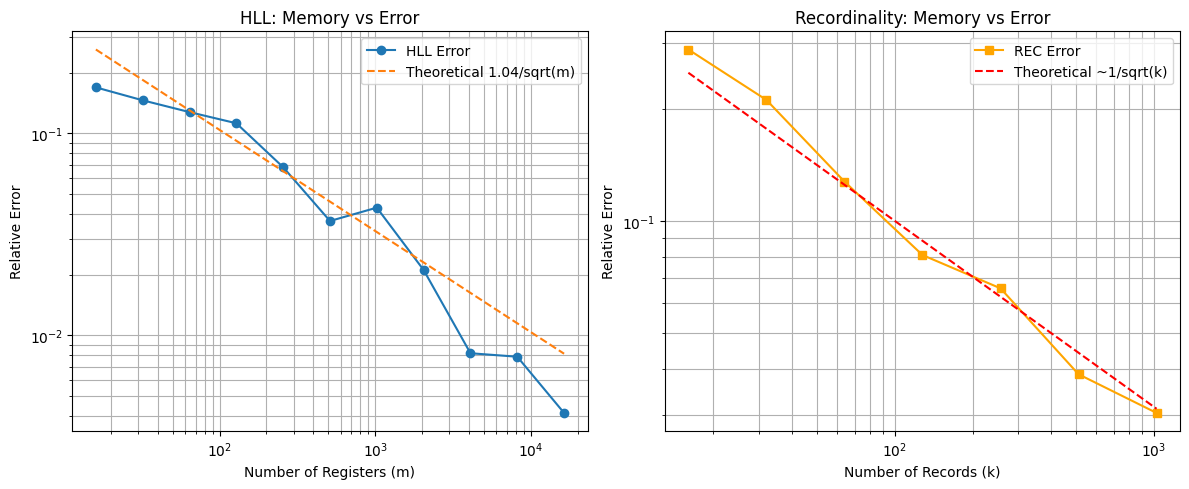

In [15]:
plot_memory_impact('dracula.txt', 'dracula.dat')

In [16]:
def test_alpha_impact():
    """
    Verifies the hypothesis that the Zipf parameter alpha
    has little impact on the estimation quality.
    """
    print("\n" + "="*60)
    print("EXPERIMENT: Impact of Zipf Parameter (Alpha)")
    print("-" * 60)

    # Parameters
    alphas = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
    N = 100000   # Stream length
    n_universe = 5000 # Size of the "Universe" of possible items
    trials = 20

    print(f"Fixed N={N}, Universe n={n_universe}")
    print(f"{'Alpha':<10} | {'True_In_Stream':<15} | {'HLL Err%':<10} | {'REC Err%':<10}")
    print("-" * 60)

    results_hll = []
    results_rec = []
    plot_alphas = []

    for alpha in alphas:
        hll_errors = []
        rec_errors = []
        true_counts = []

        for i in range(trials):
            # 1. Generate Data
            stream = generate_zipf_stream(N, n_universe, alpha)

            # 2. IMPORTANT: Calculate what is ACTUALLY in the stream
            # With high alpha, we won't see all 5000 items.
            true_n_in_stream = len(set(stream))
            true_counts.append(true_n_in_stream)

            # If the stream is effectively empty (extreme skew), skip to avoid div/0
            if true_n_in_stream < 10:
                continue

            # 3. Run Algorithms
            hll = HyperLogLog(b=10, hash_index=i)
            rec = Recordinality(k=128, hash_index=i)

            for item in stream:
                hll.add(item)
                rec.add(item)

            # 4. Calculate Error against TRUE_N_IN_STREAM (not n_universe)
            hll_errors.append(abs(hll.count() - true_n_in_stream) / true_n_in_stream * 100)
            rec_errors.append(abs(rec.count() - true_n_in_stream) / true_n_in_stream * 100)

        if not hll_errors: continue

        avg_true = int(np.mean(true_counts))
        avg_hll_err = np.mean(hll_errors)
        avg_rec_err = np.mean(rec_errors)

        results_hll.append(avg_hll_err)
        results_rec.append(avg_rec_err)
        plot_alphas.append(alpha)

        print(f"{alpha:<10.1f} | {avg_true:<15} | {avg_hll_err:<10.2f} | {avg_rec_err:<10.2f}")

    print("="*60)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(plot_alphas, results_hll, marker='o', label='HLL Error %')
    plt.plot(plot_alphas, results_rec, marker='s', label='REC Error %')

    plt.xlabel('Zipf Parameter (Alpha)')
    plt.ylabel('Relative Error (%)')
    plt.title('Impact of Data Skew (Alpha) on Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def test_scalability():
    """
    Checks performance across different orders of magnitude for n.
    Now includes BOTH HyperLogLog and Recordinality.
    """
    print("\n" + "="*80)
    print("EXPERIMENT: Scalability (Varying n)")
    print("-" * 80)

    n_values = [1000, 5000, 10000, 25000, 50000]
    N = 300000
    alpha = 1.0
    trials = 10  # increased to 10 for smoothness

    # Updated Header to include REC
    print(f"{'Universe n':<10} | {'True In Stream':<15} | {'HLL Err %':<10} | {'REC Err %':<10}")
    print("-" * 80)

    for n in n_values:
        hll_errors = []
        rec_errors = []
        true_in_streams = []

        for i in range(trials):
            # 1. Generate
            stream = generate_zipf_stream(N, n, alpha)
            true_n_in_stream = len(set(stream))
            true_in_streams.append(true_n_in_stream)

            # 2. Estimate HLL
            hll = HyperLogLog(b=10, hash_index=i)
            for item in stream: hll.add(item)
            hll_est = hll.count()

            # 3. Estimate REC
            rec = Recordinality(k=128, hash_index=i)
            for item in stream: rec.add(item)
            rec_est = rec.count()

            # 4. Calculate Errors
            hll_err = abs(hll_est - true_n_in_stream) / true_n_in_stream * 100
            rec_err = abs(rec_est - true_n_in_stream) / true_n_in_stream * 100

            hll_errors.append(hll_err)
            rec_errors.append(rec_err)

        avg_true = int(np.mean(true_in_streams))
        avg_hll_err = np.mean(hll_errors)
        avg_rec_err = np.mean(rec_errors)

        print(f"{n:<10} | {avg_true:<15} | {avg_hll_err:<10.2f} | {avg_rec_err:<10.2f}")
    print("="*80)


EXPERIMENT: Impact of Zipf Parameter (Alpha)
------------------------------------------------------------
Fixed N=100000, Universe n=5000
Alpha      | True_In_Stream  | HLL Err%   | REC Err%  
------------------------------------------------------------
0.0        | 5000            | 9.85       | 14.33     
0.5        | 4999            | 9.85       | 12.97     
1.0        | 4854            | 10.20      | 11.40     
1.5        | 1983            | 7.81       | 8.68      
2.0        | 423             | 7.04       | 4.36      
2.5        | 130             | 4.96       | 0.11      
3.0        | 58              | 1.73       | 0.00      


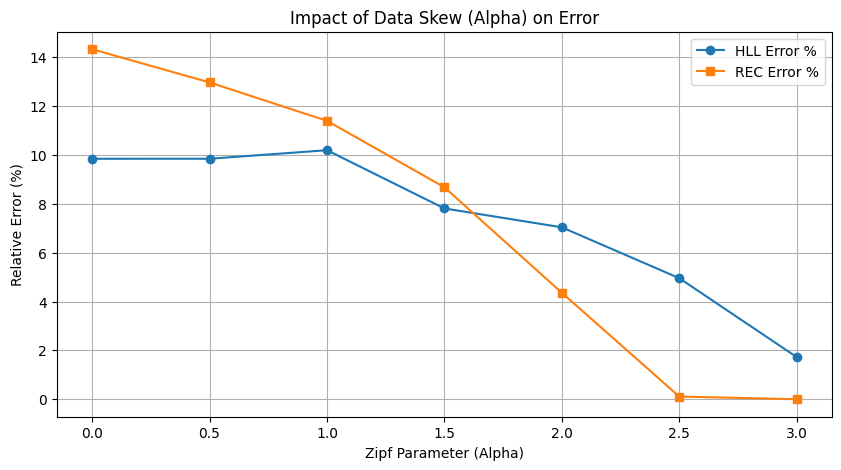

In [18]:
test_alpha_impact()

In [19]:
test_scalability()


EXPERIMENT: Scalability (Varying n)
--------------------------------------------------------------------------------
Universe n | True In Stream  | HLL Err %  | REC Err % 
--------------------------------------------------------------------------------
1000       | 1000            | 23.00      | 7.07      
5000       | 4999            | 10.01      | 13.86     
10000      | 9898            | 7.50       | 16.26     
25000      | 21886           | 4.06       | 18.04     
50000      | 34435           | 4.03       | 18.98     


In [20]:
def test_recordinality_hashing_necessity():
    print("\n" + "="*60)
    print("BONUS: Verifying When Hashing is Needed for Recordinality")
    print("-" * 60)

    N = 50000
    n = 2000
    trials = 5

    # Case A: Skewed Data (Alpha=2.0)
    # If we DON'T hash this, Recordinality should fail or be very biased because
    # the data isn't "randomly distributed" across the number line.
    print(f"Testing on Skewed Data (Alpha=2.0) WITHOUT internal hashing...")

    rec_errors = []
    for i in range(trials):
        # Generate skewed integers
        stream = generate_zipf_stream(N, n, alpha=2.0)

        # Initialize REC manually to simulate "No Hash"
        # We cheat slightly: we just pass the raw integer as the 'hash'
        current_k_set = set()
        k = 128
        R = 0

        for item in stream:
            # NO HASHING: Treat item value as its own hash
            val = int(item)

            # Standard REC logic
            if len(current_k_set) < k:
                if val not in current_k_set:
                    current_k_set.add(val)
                    R += 1
            else:
                current_min = min(current_k_set)
                if val > current_min and val not in current_k_set:
                    current_k_set.remove(current_min)
                    current_k_set.add(val)
                    R += 1

        # Estimate
        exponent = R - k + 1
        est = k * ((1 + 1.0/k) ** exponent) - 1
        rec_errors.append(abs(est - n)/n * 100)

    avg_err = np.mean(rec_errors)
    print(f"-> Average Error WITHOUT hashing on Skewed Data: {avg_err:.2f}% (Expect High Error)")
    print("-" * 60)

In [21]:
test_recordinality_hashing_necessity()


BONUS: Verifying When Hashing is Needed for Recordinality
------------------------------------------------------------
Testing on Skewed Data (Alpha=2.0) WITHOUT internal hashing...
-> Average Error WITHOUT hashing on Skewed Data: 79.32% (Expect High Error)
------------------------------------------------------------


In [22]:
def run_batch_experiments():
    # List of all your datasets
    datasets = [
        "dracula", "midsummer-nights-dream", "mare-balena",
        "crusoe", "iliad", "quijote", "war-peace", "valley-fear"
    ]

    # Store results for plotting
    names_for_plot = []
    true_ns = []
    hll_errors = []
    rec_errors = []

    print("\n" + "="*80)
    print(f"{'Dataset':<25} | {'True n':<8} | {'HLL Err%':<9} | {'REC Err%':<9}")
    print("-" * 80)

    b = 10
    k = 128
    trials = 50

    for name in datasets:
        txt_file = f"{name}.txt"
        dat_file = f"{name}.dat"

        true_n = get_true_cardinality(dat_file)
        if true_n == 0: continue

        try:
            with open(txt_file, 'r', encoding='utf-8', errors='ignore') as f:
                stream = f.read().split()
        except FileNotFoundError:
            continue

        # Run Trials
        hll_batch_err = []
        rec_batch_err = []

        for i in range(trials):
            hll = HyperLogLog(b=b, hash_index=i)
            rec = Recordinality(k=k, hash_index=i)
            for item in stream:
                hll.add(item)
                rec.add(item)

            # Calculate individual trial errors
            hll_batch_err.append(abs(hll.count() - true_n) / true_n * 100)
            rec_batch_err.append(abs(rec.count() - true_n) / true_n * 100)

        # Average the errors
        avg_hll_err = np.mean(hll_batch_err)
        avg_rec_err = np.mean(rec_batch_err)

        # Print Table Row
        print(f"{name:<25} | {true_n:<8} | {avg_hll_err:<8.2f}% | {avg_rec_err:<8.2f}%")

        # Save for plotting
        names_for_plot.append(name)
        true_ns.append(true_n)
        hll_errors.append(avg_hll_err)
        rec_errors.append(avg_rec_err)

    print("="*80 + "\n")

    # --- PLOT 1: Bar Chart Comparison ---
    x = np.arange(len(names_for_plot))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, hll_errors, width, label='HLL Error %')
    plt.bar(x + width/2, rec_errors, width, label='REC Error %')

    plt.ylabel('Relative Error (%)')
    plt.title('Algorithm Accuracy across Different Datasets')
    plt.xticks(x, names_for_plot, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: Stability (Size vs Error) ---
    plt.figure(figsize=(8, 5))
    plt.scatter(true_ns, hll_errors, color='blue', label='HLL', s=100, alpha=0.7)
    plt.scatter(true_ns, rec_errors, color='orange', label='REC', marker='s', s=100, alpha=0.7)
    plt.xscale('log') # Use log scale because "War and Peace" is HUGE
    plt.xlabel('True Cardinality (n) [Log Scale]')
    plt.ylabel('Relative Error (%)')
    plt.title('Stability Check: Error vs Dataset Size')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


Dataset                   | True n   | HLL Err%  | REC Err% 
--------------------------------------------------------------------------------
dracula                   | 9425     | 3.10    % | 12.38   %
midsummer-nights-dream    | 3136     | 3.59    % | 10.96   %
mare-balena               | 5670     | 2.20    % | 12.61   %
crusoe                    | 6245     | 2.48    % | 12.66   %
iliad                     | 8925     | 2.48    % | 11.57   %
quijote                   | 23034    | 2.57    % | 15.22   %
war-peace                 | 17475    | 2.05    % | 15.28   %
valley-fear               | 5829     | 2.44    % | 11.80   %



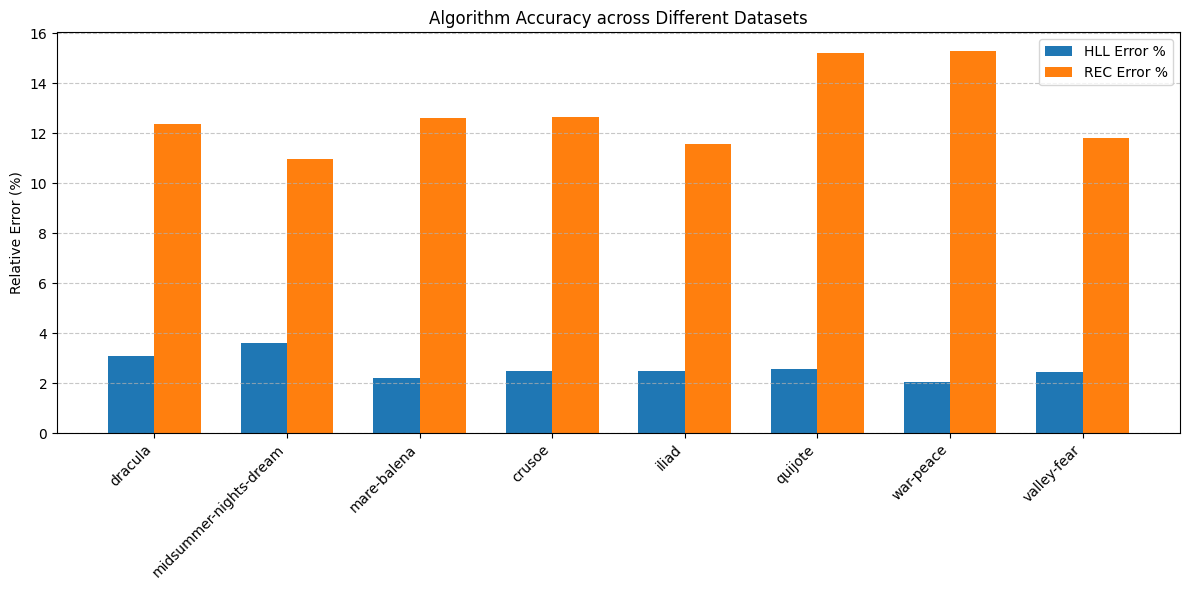

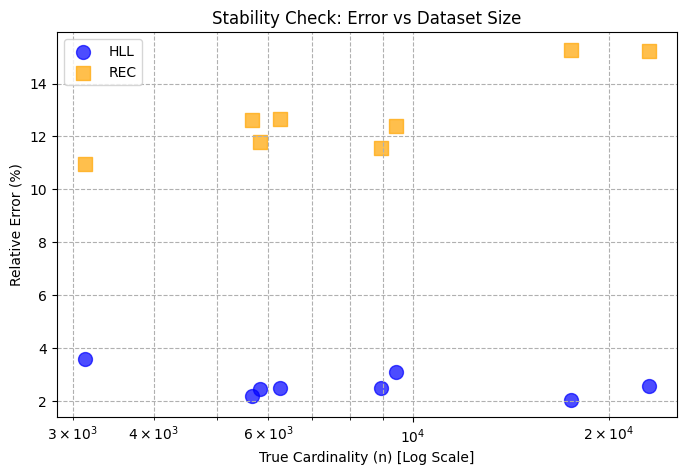

In [23]:
run_batch_experiments()

In [24]:
# --- BONUS ALGORITHM: KMV (K-Minimum Values) ---
class KMV:
    def __init__(self, k, hash_index=0):
        """
        k: The number of minimum values to keep.
        """
        self.k = k
        self.hash_index = hash_index
        self.current_k_set = set()
        # We work with 32-bit integers, so the max possible hash is 2^32 - 1
        self.limit_32bit = 0xFFFFFFFF

    def add(self, item):
        # 1. Get Hash (Same as others)
        h = global_hasher.get_hash(item, self.hash_index) & self.limit_32bit

        # 2. Maintain the k-smallest values
        if len(self.current_k_set) < self.k:
            self.current_k_set.add(h)
        else:
            # We want the SMALLEST values.
            # So the "worst" value we have currently is the LARGEST in our set.
            current_max = max(self.current_k_set)

            if h < current_max and h not in self.current_k_set:
                self.current_k_set.remove(current_max)
                self.current_k_set.add(h)

    def count(self):
        # Case 1: If we haven't filled the buffer, the count is exact.
        if len(self.current_k_set) < self.k:
            return len(self.current_k_set)

        # Case 2: KMV Estimator
        # Formula: (k - 1) / U_k
        # where U_k is the k-th smallest hash normalized to [0,1]

        k_th_smallest = max(self.current_k_set) # This is the largest in our set of smalls
        U_k = k_th_smallest / float(self.limit_32bit)

        estimate = (self.k - 1) / U_k
        return int(estimate)

In [25]:
def run_batch_experiments_with_bonus():
    datasets = [
        "dracula", "midsummer-nights-dream", "mare-balena",
        "crusoe", "iliad", "quijote", "war-peace", "valley-fear"
    ]

    # Store results for plotting
    names_for_plot = []
    hll_errors = []
    rec_errors = []
    kmv_errors = [] # NEW

    print("\n" + "="*100)
    print(f"{'Dataset':<20} | {'True n':<8} | {'HLL %':<8} | {'REC %':<8} | {'KMV % (Bonus)':<12}")
    print("-" * 100)

    b = 10
    k = 128
    trials = 50

    for name in datasets:
        txt_file = f"{name}.txt"
        dat_file = f"{name}.dat"

        true_n = get_true_cardinality(dat_file)
        if true_n == 0: continue

        try:
            with open(txt_file, 'r', encoding='utf-8', errors='ignore') as f:
                stream = f.read().split()
        except FileNotFoundError:
            continue

        hll_batch_err = []
        rec_batch_err = []
        kmv_batch_err = [] # NEW

        for i in range(trials):
            # Init all 3 algorithms
            hll = HyperLogLog(b=b, hash_index=i)
            rec = Recordinality(k=k, hash_index=i)
            kmv = KMV(k=k, hash_index=i) # Same memory k as Rec

            for item in stream:
                hll.add(item)
                rec.add(item)
                kmv.add(item)

            # Calculate Errors
            hll_batch_err.append(abs(hll.count() - true_n) / true_n * 100)
            rec_batch_err.append(abs(rec.count() - true_n) / true_n * 100)
            kmv_batch_err.append(abs(kmv.count() - true_n) / true_n * 100)

        avg_hll = np.mean(hll_batch_err)
        avg_rec = np.mean(rec_batch_err)
        avg_kmv = np.mean(kmv_batch_err)

        print(f"{name:<20} | {true_n:<8} | {avg_hll:<8.2f} | {avg_rec:<8.2f} | {avg_kmv:<12.2f}")

        names_for_plot.append(name)
        hll_errors.append(avg_hll)
        rec_errors.append(avg_rec)
        kmv_errors.append(avg_kmv)

    print("="*100 + "\n")

    # --- PLOT: 3-Way Comparison ---
    x = np.arange(len(names_for_plot))
    width = 0.25 # Thinner bars to fit 3

    plt.figure(figsize=(14, 6))
    plt.bar(x - width, hll_errors, width, label='HLL')
    plt.bar(x, rec_errors, width, label='REC')
    plt.bar(x + width, kmv_errors, width, label='KMV (Bonus)', color='green')

    plt.ylabel('Relative Error (%)')
    plt.title('Bonus Study: Comparing HLL, REC, and KMV')
    plt.xticks(x, names_for_plot, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Dataset              | True n   | HLL %    | REC %    | KMV % (Bonus)
----------------------------------------------------------------------------------------------------
dracula              | 9425     | 3.10     | 12.38    | 7.50        
midsummer-nights-dream | 3136     | 3.59     | 10.96    | 6.78        
mare-balena          | 5670     | 2.20     | 12.61    | 7.07        
crusoe               | 6245     | 2.48     | 12.66    | 7.27        
iliad                | 8925     | 2.48     | 11.57    | 6.82        
quijote              | 23034    | 2.57     | 15.22    | 7.79        
war-peace            | 17475    | 2.05     | 15.28    | 7.72        
valley-fear          | 5829     | 2.44     | 11.80    | 7.46        



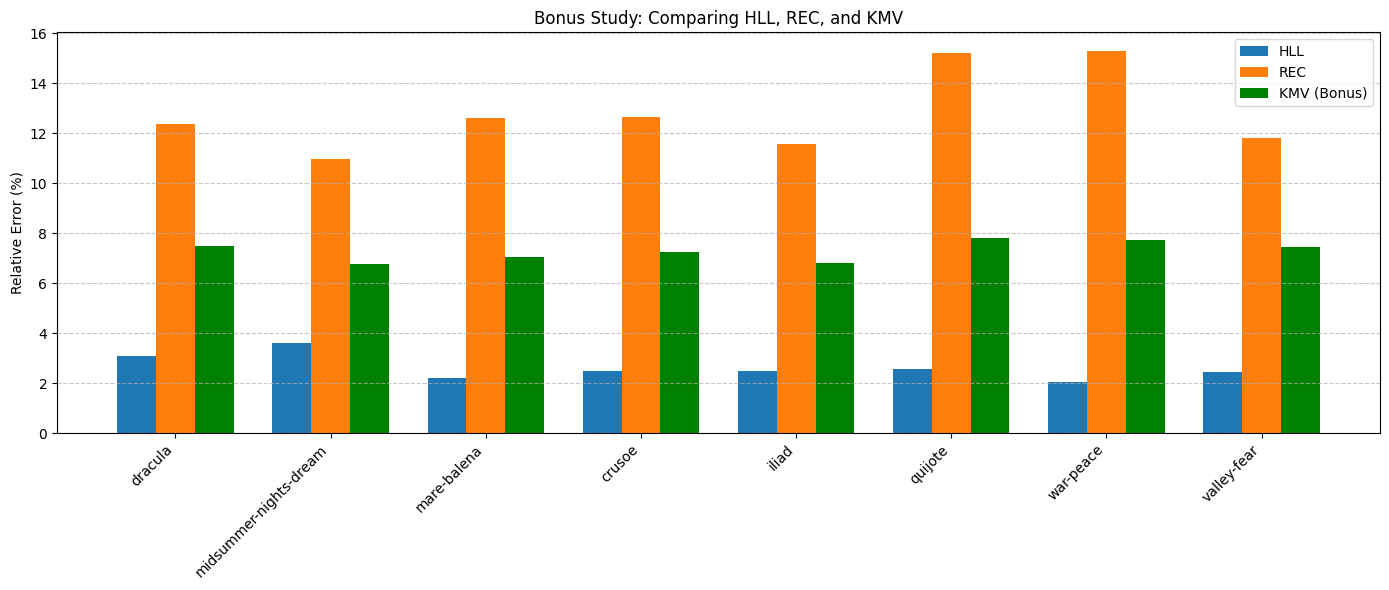

In [26]:
run_batch_experiments_with_bonus()

In [27]:
end_time = time.time()
elapsed_seconds = end_time - start_time

hours, remainder = divmod(elapsed_seconds, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Execution time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Execution time: 7h 9m 8.51s
